#### Classification | Model

# Predicting Heart Disease  

### Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exporatory Data Analysis](#3)<br/>
   [Data Summary](#31)<br/>
   [Classification Viability](#32)<br/>
   [Classification Metrics](#33)<br/>
4. [Baselining](#4)<br/>
5. [Validation](#5)<br/>
6. [Model Iterations](#6) <br/>
    1 [Dummy Classifier](#61)<br/>
    2 [Logistic Regression](#62)<br/>
    3 [Decision Trees: Depth 2](#63)<br/>
    4 [Decision Trees: Depth 4](#64)<br/>
    5 [Random Forests](#65)<br/>
    6 [Gradient Boosted Trees: xgboost](#66)<br/>
    7 [Naive Bayes: Bernoulli](#67)<br/>
    8 [Naive Bayes: Gaussian](#68)<br/>
    9 [Naive Bayes: Multinomial](#69)<br/>
    10 [Ensemble:  Naive Bayes Hard Voting Classifier](#610)<br/>
    11 [Ensemble:  Naive Bayes Soft Voting Classifier](#611)<br/>
    12 [Ensemble:  Stacking Classifier (non-NBs)](#612)<br/>
    [Feature Engineering](#fe)<br/>
    13 [Logistic regression: Question groups](#613)<br/>
    14 [Logistic regression: Risk factors](#614)<br/>
    15 [Logistic regression: Question groups + Risk factor features](#615)<br/>
    [Class Imbalance Handling](#cih)<br/>
    16 [Logistic regression: threshold = 0.05](#616)<br/>
    [Model Tuning: GridSearchCV](#gscv)<br/>
    17 [Logistic regression: GridSearchCV](#616)<br/>
7. [Model: Predicting Heart Disease ](#7)<br/>
    [Test Model](#71)<br/>
    [Confusion Matrix](#72)<br/>
    [ROC AUC (X, y)](#73) <br/>
    [Feature Importance](#74) <br/>
    [Interpret](#75)


In [1]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import dataframe_image as dfi
import pickle
import warnings
warnings.filterwarnings("ignore")
# import plotly.express as px
# import plotly.graph_objects as go
                        
plt.style.use('ggplot')
%matplotlib inline
sns.set_style("whitegrid")

np.set_printoptions(suppress=True)

from mlxtend.classifier import StackingClassifier
from plotly.subplots import make_subplots           
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# 1 | Research Design<a id='1'></a> 

* **Reserach Question:** How might we predict which patients are at high risk of heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>
_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

[back to top](#top)

# 2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


In [2]:
# load clean and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('heart_disease_df.csv')
heart_disease_df_map = pd.read_csv('heart_disease_df_map.csv') 


In [ ]:
# clean df
heart_disease_df.head(3)


In [ ]:
# transformed df: mapped categorical variables to numerical values 
heart_disease_df_map.head(3)


[back to top](#top)

# 3 | Exporatory Data Analysis<a id='3'></a> 

#### Using `heart_disease_df_map` with mapped variables for modeling.
##### Note: Full EDA part of [MVP](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).

### 3.1 Data Summary<a id='31'></a> 

In [ ]:
# dataframe info
heart_disease_df_map.info()


#### No missing data, all data types are numerical.

[back to top](#top)

### 3.2 Classification Viability<a id='32'></a> 

In [ ]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')


In [ ]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')


#### A classification model is viable.

[back to top](#top)

In [ ]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


[back to top](#top)

### 3.3 Classification Metrics<a id='33'></a> 

* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients. 

[back to top](#top)

# 4 | Baseline<a id='4'></a> 

#### Logistic regression with three features based on correlation matrix.

In [ ]:
# separate target from features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease'] 
X_base = heart_disease_df_map.loc[:, [
#     'behavior_activity', 
#     'behavior_alcohol', 
#     'behavior_sleep',
#     'behavior_tobacco',
    'demg_age',
#     'demg_gender', 
#     'demg_race',
#     'disease_asthma', 
#     'disease_diabetes', 
#     'disease_kidney', 
#     'disease_skin', 
#     'disease_stroke', 
#     'health_bmi', 
#     'health_general', 
#     'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split baseline data test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,
                                                                        y_base,
                                                                        test_size=0.2,
                                                                        random_state=42)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base, 
                                                                                y_train_base, 
                                                                                test_size = .25, 
                                                                                random_state = 42)

# scale baseline X train/test
scaler = StandardScaler()
X_train_scaled_base = scaler.fit_transform(X_train_base)
X_test_scaled_base = scaler.transform(X_test_base)
X_val_scaled_base = scaler.transform(X_val_base)


In [ ]:
# baseline logistic regression X train scaled & y train
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m 
y_pred_base = log_reg_base.predict(X_val_scaled_base) 

In [ ]:
# score on recall and roc auc
zero = ["Baseline logistic regression", 'log_reg_base',
        recall_score(y_pred_base, y_val_base),
        roc_auc_score(y_val_base, log_reg_base.predict_proba(X_val_scaled_base)[:,1])]
zero

[back to top](#top)

# 5 | Validation<a id='5'></a>

#### Validation and testing scheme to use in [model selection](#7). 

In [3]:
# separate target from features 
y = heart_disease_df_map['y_heart_disease'] 
X = heart_disease_df_map.loc[:, [
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split data test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size = .25, 
                                                            random_state = 42)

# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X) 


[back to top](#top)

# 6 | Model Iterations <a id='6'></a> 

### 6.1 Dummy Classifier<a id='61'></a> 

In [ ]:
clf = DummyClassifier(strategy= 'most_frequent')
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_val)


In [ ]:
one = ["Dummy classifier", 'clf',
         recall_score(y_pred_clf, y_val), 
         roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])]
one

#### Dummy classifier performed worse than [baseline](#4).<br/>

[back to top](#top)

### 6.2 Logistic Regression<a id='62'></a> 

In [4]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled) 


In [5]:
two = ["Logistic regression", 'log_reg',
       recall_score(y_pred_log_reg, y_val), 
       roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])]
two

['Logistic regression', 'log_reg', 0.5195052331113226, 0.8411422086561615]

#### Logistic regression (with all features) performed better than [baseline](#4).<br/>

In [43]:
# confusion matrix for log_reg

cm_log_reg = confusion_matrix(y_val, y_pred_log_reg)
cm_log_reg


array([[57968,   505],
       [ 4940,   546]])

[back to top](#top)

### 6.3 Decision Trees: Depth 2<a id='63'></a> 

In [ ]:
dt_2 = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_2.fit(X_train, y_train)
y_pred_dt_2 = dt_2.predict(X_val)


In [ ]:
three = ["Decision tree (depth=2)", 'dt_2', 
       recall_score(y_pred_dt_2, y_val), 
       roc_auc_score(y_val, dt_2.predict_proba(X_val)[:,1])]
three

In [ ]:
tree.plot_tree(dt_2);

### 6.4 Decision Trees: Depth 4<a id='64'></a> 

In [ ]:
dt_4 = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt_4.fit(X_train, y_train)
y_pred_dt_4 = dt_4.predict(X_val)


In [ ]:
four = ["Decision tree (depth=4)", 'dt_4',
         recall_score(y_pred_dt_4, y_val),
         roc_auc_score(y_val, dt_4.predict_proba(X_val)[:,1])]
four

In [ ]:
tree.plot_tree(dt_4);

#### Decsion trees performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.5 Random Forests <a id='65'></a> 

In [ ]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_forest = forest.predict(X_val)


In [ ]:
five = ["Random forest", 'forest',
        recall_score(y_pred_forest, y_val),
        roc_auc_score(y_val, forest.predict_proba(X_val)[:,1])]
five

#### Random forest performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.6 Gradient Boosted Trees: xgboost<a id='66'></a> 

In [ ]:
# XGBoost

gbm = xgb.XGBRegressor( 
                    n_estimators=30000,
                    max_depth=3,
                    objective="binary:logistic",
                    eval_metric='auc',
                    learning_rate=.1,
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8
                    )

eval_set=[(X_train, y_train),(X_val,y_val)] 

gbm_fit = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
#                     eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True 
                   )

#### [220]	validation_0-auc: 0.84848	validation_1-auc: 0.84449


In [ ]:
y_pred_gbm = gbm.predict(X_val)
y_pred_gbm

In [ ]:
six = ["XGBoost", 'gbm',
        recall_score(y_val, np.round(gbm.predict(X_val))), 
        roc_auc_score(y_val, np.round(gbm.predict(X_val)))]
six


#### XGBoost performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.7. Naive Bayes: Bernoulli<a id='67'></a> 

In [ ]:
# BernoulliNB() 
bern = BernoulliNB().fit(X_train, y_train)
y_predict_bern = bern.predict(X_val) 


In [ ]:
seven = ["Bernoulli NB", 'bern',
       recall_score(y_predict_bern, y_val),
       roc_auc_score(y_val, bern.predict_proba(X_val)[:,1])]

five

### 6.8. Naive Bayes: Gaussian<a id='68'></a> 

In [ ]:
gaus = GaussianNB().fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_val)


In [ ]:
eight = ["Gaussian NB",'gaus',
         recall_score(y_pred_gaus, y_val),
         roc_auc_score(y_val, gaus.predict_proba(X_val)[:,1])]
eight

### 6.9. Naive Bayes: Multinomial<a id='69'></a> 

In [ ]:
multi = MultinomialNB().fit(X_train, y_train)
y_pred_multi = multi.predict(X_val)


In [ ]:
nine = ["Multinomial NB", 'multi',
        recall_score(y_pred_multi, y_val),
        roc_auc_score(y_val, multi.predict_proba(X_val)[:,1])]
nine

#### Naive Bayes performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.10 Ensemble: Naive Bayes Hard Voting Classifier <a id='610'></a> 

In [ ]:
# set up voting classifier ensemble

nb_names = ['bern', 'gaus', 'multi']
nb_vars = [eval(n) for n in nb_names]

nb_list = list(zip(nb_names, nb_vars))
nb_list


In [ ]:
vote_hard = VotingClassifier(estimators= nb_list,
                             voting='hard',
                             n_jobs=-1)
vote_hard.fit(X_train, y_train)
y_pred_hard = vote_hard.predict(X_val)


In [ ]:
ten = ["Hard NB Voting Classifier", 'vote_hard',
       recall_score(y_pred_hard, y_val),
       roc_auc_score(y_val, vote_hard.predict(X_val))]
ten

### 6.11 Ensemble: Naive Bayes Soft Voting Classifier <a id='611'></a> 

In [ ]:
vote_soft = VotingClassifier(estimators= nb_list,
                             voting='soft',
                             n_jobs=-1)

vote_soft.fit(X_train, y_train)
y_pred_soft = vote_soft.predict(X_val)


In [ ]:
eleven = ["Soft NB Voting Classifier", 'vote_soft',
       recall_score(y_pred_soft, y_val), 
       roc_auc_score(y_val, vote_soft.predict_proba(X_val)[:,1])]
eleven

#### Voting classifer ensemble of Naive Bayes performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.12 Ensemble:  Stacking Classifier (non-NBs) <a id='612'></a> 

In [ ]:
model_names = ['clf', 'log_reg', 'dt_2', 'dt_4', 'forest', 'gbm']

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))
model_list

In [ ]:
stacked = StackingClassifier(classifiers= model_list, 
                             meta_classifier=LogisticRegression(),
                             use_probas=False) 

In [ ]:
# stacked.fit(X_train, y_train)
# y_pred_stack = stacked.predict(X_val)


In [ ]:
# tweleve = ["Stacked", 'stacked',
#           recall_score(y_pred_stack, y_val),
#           roc_auc_score(y_val, stacked.predict_proba(X_val)[:,1])]
# tweleve

#### Stacking ensemble (excluding Naive Bayes) performed worse than [logistic regression](#62). 


[back to top](#top)

## Feature Engineering <a id='fe'></a> 

### Features: Question groups
Groups of similar survey question questions as defined by [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf).

In [ ]:
# 1 behaviors = phyiscial activity days/month + sleep time hrs/day + alcohol + tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +  
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age + gender + race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +  
    heart_disease_df_map['demg_race'])

# 3 disease = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +  
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 (health) measures = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +  
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


### Features: Risk factors
Heart disease risk factors by [CDC](https://www.cdc.gov/heartdisease/facts.htm). 

In [ ]:
# risk factors = diabetes + bmi + physical activity + alcohol
heart_disease_df_map['risk_factors'] = (
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['health_bmi'] +  
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'])

heart_disease_df_map.columns


### 6.13 Logistic regression: question groups<a id='613'></a> 

In [ ]:
# separate target from question groups features: y/X_grp
y_grp = heart_disease_df_map['y_heart_disease'] 
X_grp = heart_disease_df_map.loc[:, ['behaviors', 
                                   'demographics', 
                                   'disease', 
                                   'measures']]

# split data test/train/validate
X_train_grp, X_test_grp, y_train_grp, y_test_grp = train_test_split(X_grp, 
                                                    y_grp, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_grp, X_val_grp, y_train_grp, y_val_grp = train_test_split(X_train_grp, 
                                                                    y_train_grp, 
                                                                    test_size = .25, 
                                                                    random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_scaled = scaler.fit_transform(X_train_grp)
X_test_grp_scaled = scaler.transform(X_test_grp)
X_val_grp_scaled = scaler.transform(X_val_grp)


In [ ]:
# LR question groups features
log_reg_grp = LogisticRegression()
log_reg_grp.fit(X_train_grp_scaled, y_train_grp)
y_pred_grp = log_reg_grp.predict(X_val_grp_scaled) 


In [ ]:
thirteen = ["Logistic regression group features", 'log_reg_grp',
           recall_score(y_pred_grp, y_val_grp), 
           roc_auc_score(y_val_grp, log_reg_grp.predict_proba(X_val_grp_scaled)[:,1])]
thirteen

[back to top](#top)

### 6.14 Logistic regression: risk factors<a id='614'></a> 

In [ ]:
# separate target from engineered features: y/X_risk
y_risk = heart_disease_df_map['y_heart_disease'] 
X_risk = heart_disease_df_map.loc[:, ['disease_diabetes',
                                    'health_bmi',
                                    'behavior_activity', 
                                   'behavior_alcohol']]

# split data test/train/validate
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, 
                                                    y_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_risk, X_val_risk, y_train_risk, y_val_risk = train_test_split(X_train_risk, 
                                                                        y_train_risk, 
                                                                        test_size = .25, 
                                                                        random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_risk_scaled = scaler.fit_transform(X_train_risk)
X_test_risk_scaled = scaler.transform(X_test_risk)
X_val_risk_scaled = scaler.transform(X_val_risk)


In [ ]:
# LR risk factor features
log_reg_risk = LogisticRegression()
log_reg_risk.fit(X_train_risk_scaled, y_train_risk)
y_pred_risk = log_reg_risk.predict(X_val_risk_scaled) 


In [ ]:
fourteen = ["Logistic regression risk factor features", 'log_reg_risk',
            recall_score(y_pred_risk, y_val_risk), 
            roc_auc_score(y_val_risk, log_reg_risk.predict_proba(X_val_risk_scaled)[:,1])]
fourteen

[back to top](#top)

### 6.15 Logistic regression: question groups + risk factor features<a id='615'></a> 

In [ ]:
# separate target from question groups + risk factor features: y/X_grp_risk
y_grp_risk = heart_disease_df_map['y_heart_disease'] 
X_grp_risk = heart_disease_df_map.loc[:, [
    'behaviors', 
    'demographics', 
    'disease', 
    'measures',
    'behavior_activity',
    'behavior_alcohol',
    'disease_diabetes',
    'health_bmi'
    ]]

# split data test/train/validate
X_train_grp_risk, X_test_grp_risk, y_train_grp_risk, y_test_grp_risk = train_test_split(X_grp_risk, 
                                                    y_grp_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train_grp_risk, X_val_grp_risk, y_train_grp_risk, y_val_grp_risk = train_test_split(X_train_grp_risk, 
                                                                            y_train_grp_risk, 
                                                                            test_size = .25, 
                                                                            random_state = 42)

# Scale X train/test/validate
scaler = StandardScaler()
X_train_grp_risk_scaled = scaler.fit_transform(X_train_grp_risk)
X_test_grp_risk_scaled = scaler.transform(X_test_grp_risk)
X_val_grp_risk_scaled = scaler.transform(X_val_grp_risk)


In [ ]:
# LR question groups + risk factor features
log_reg_grp_risk = LogisticRegression()
log_reg_grp_risk.fit(X_train_grp_risk_scaled, y_train_grp_risk)
y_pred_grp_risk = log_reg_grp_risk.predict(X_val_grp_risk_scaled) 


In [ ]:
fifteen = ["Logistic regression question groups + risk factor features", 'log_reg_grp_risk',
            recall_score(y_pred_grp_risk, y_val_grp_risk), 
            roc_auc_score(y_val_grp_risk, log_reg_grp_risk.predict_proba(X_val_grp_risk_scaled)[:,1])]
fifteen

#### Models with feature engineering performed worse than [logistic regression](#62). 

[back to top](#top)

## Class Imblance Handling <a id='cih'></a> 

In [46]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

0    292422
1     27373
Name: y_heart_disease, dtype: int64

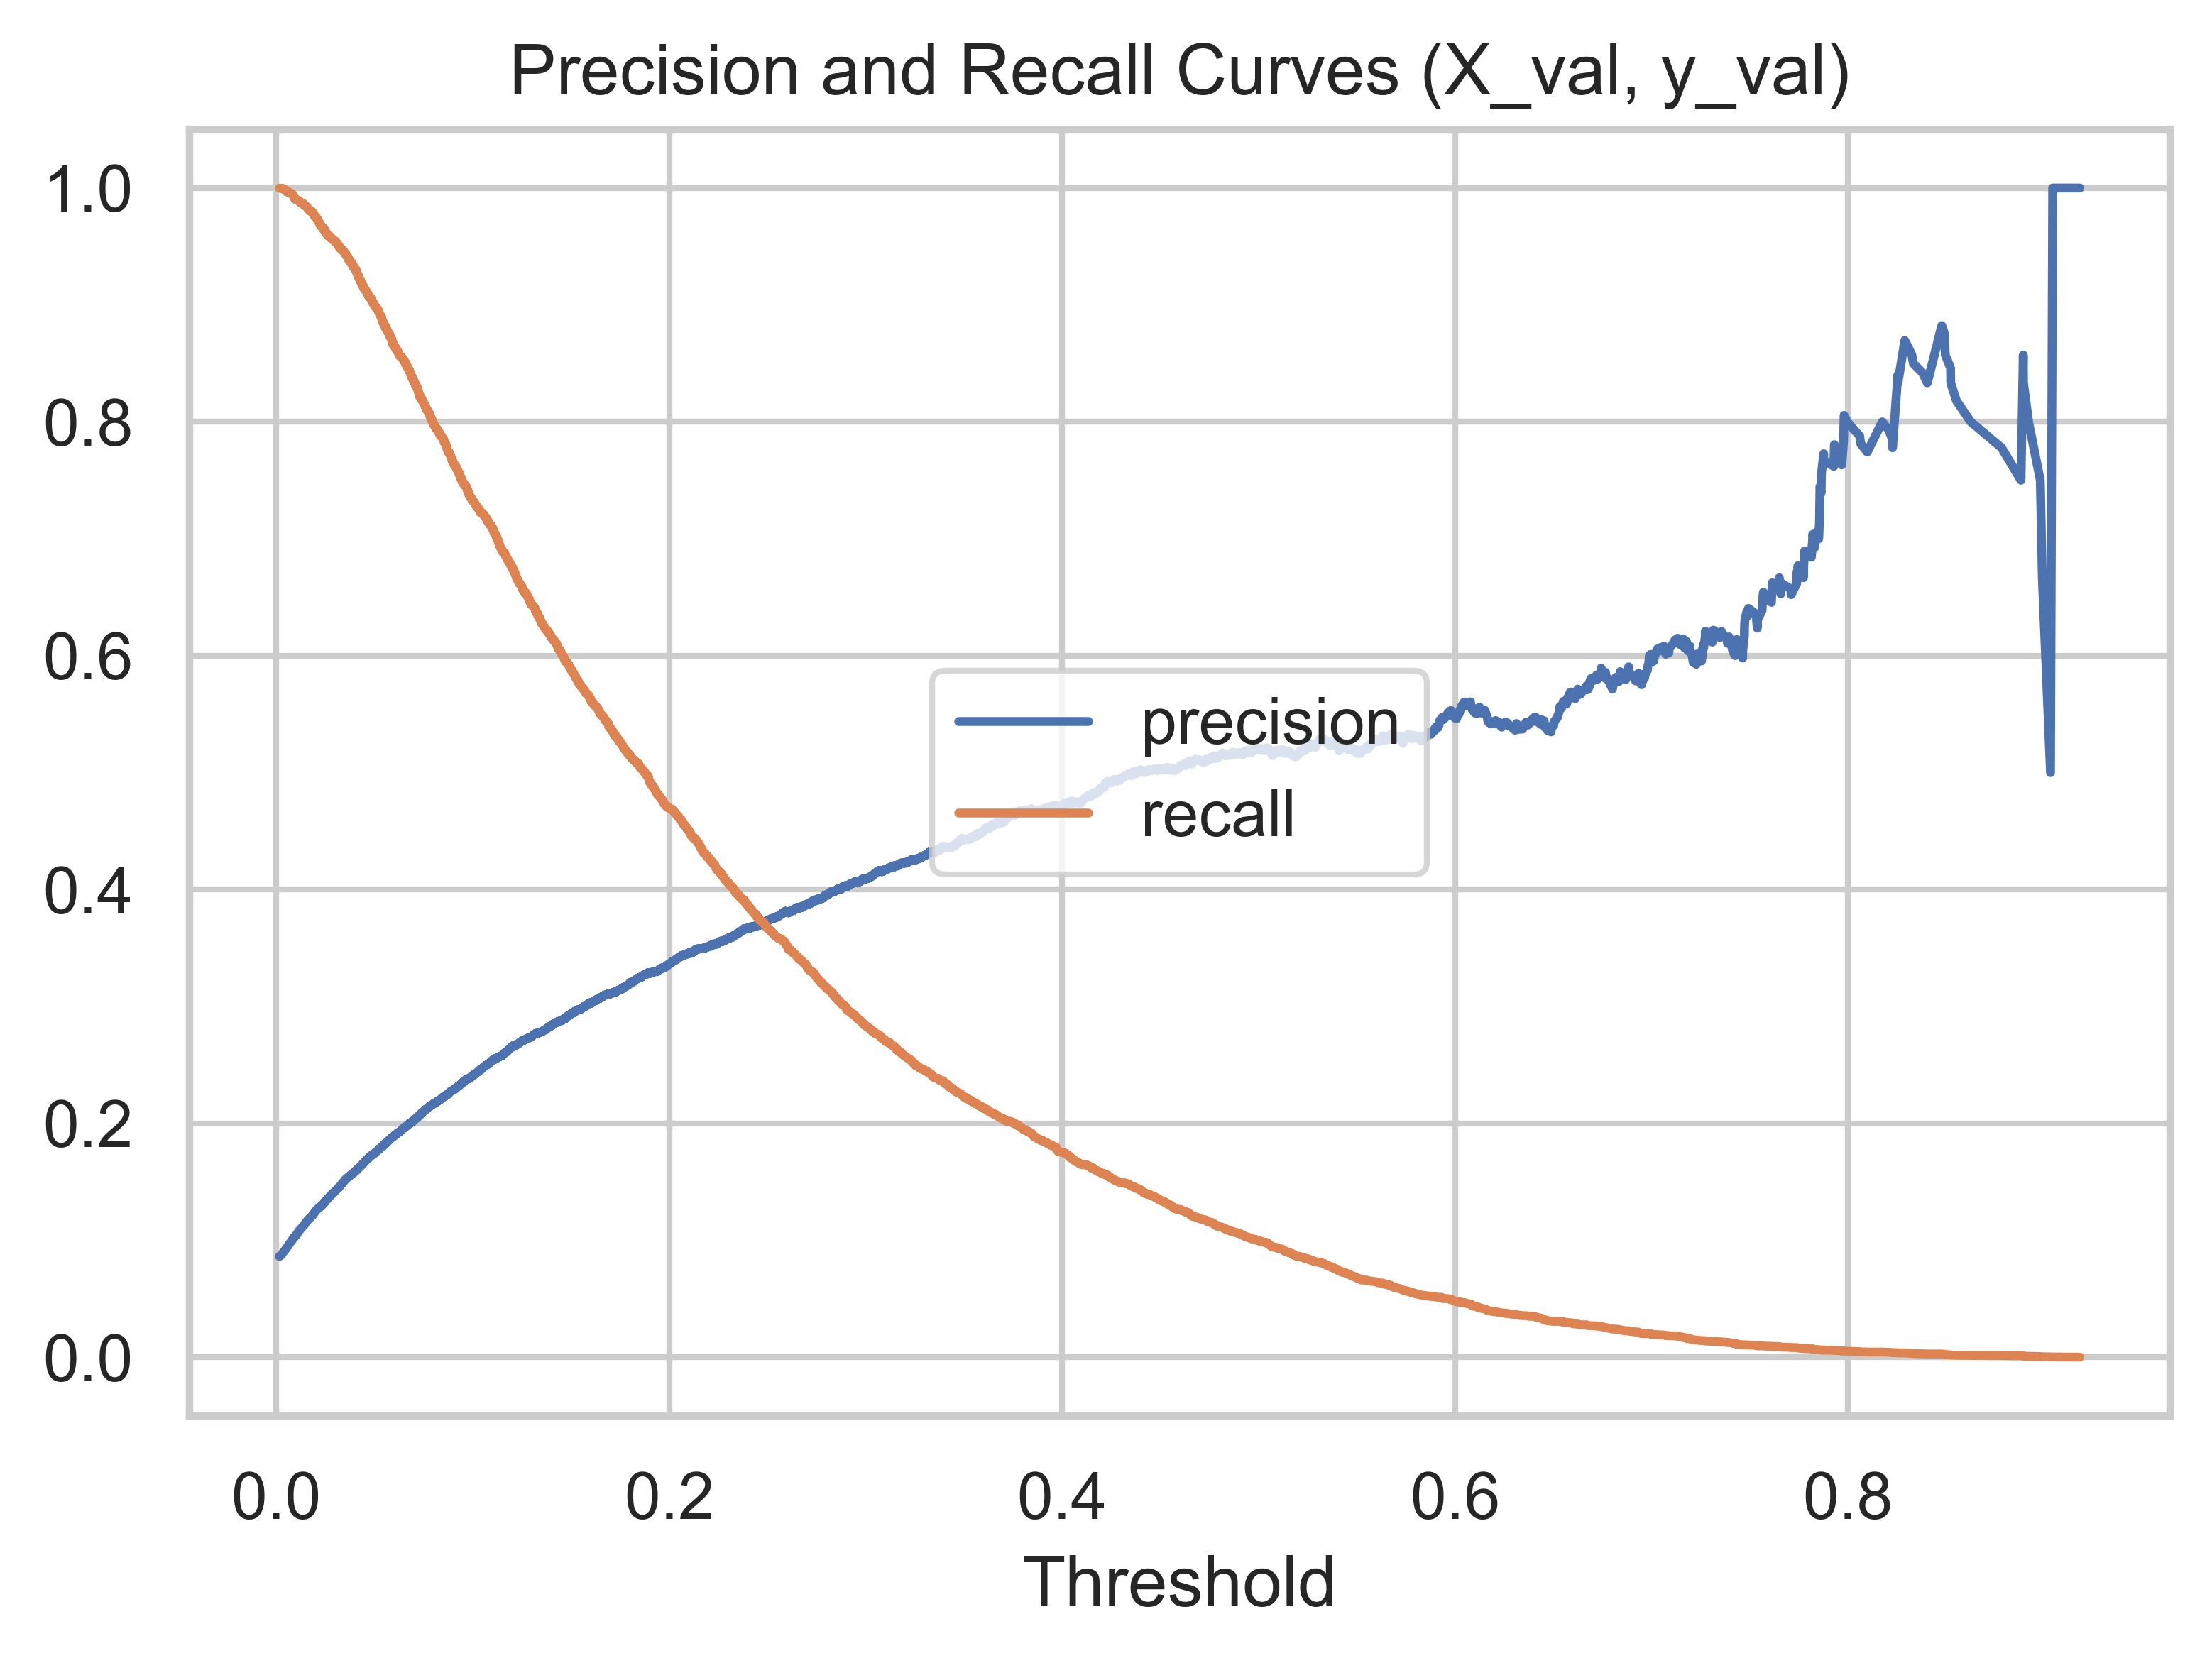

In [59]:
# precision and recall curves for X/y_val
y_pred = log_reg.predict(X_val_scaled) 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_val, log_reg.predict_proba(X_val_scaled)[:,1] )

# f, ax = plt.subplots(figsize=(10, 6))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='center')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves (X_val, y_val)')
plt.savefig("precision-recall-curves.jpeg");

### 6.16 Logistic regression: threshold = 0.05<a id='616'></a> 


In [71]:
# decision threshold = 0.25 based on precision and recall curves
y_predict = (log_reg.predict_proba(X_val_scaled)[:,1] > 0.05)

sixteen = ["Logistic regression threshold = 0.05", 'log_reg',
            recall_score(y_predict, y_val), 
            roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])]
sixteen

['Logistic regression threshold = 0.05',
 'log_reg',
 0.17449427075965482,
 0.8411422086561615]

In [ ]:
# add model to model_eval df
sixteen = {
    'Model': 'Logistic regression threshold = 0.05', 
    'Variable': 'log_reg', 
    'Recall': recall_score(y_predict, y_val) ,
    'ROC AUC': roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])
}
model_eval = model_eval.append(sixteen, ignore_index = True)


#### Model with lower decision threshold performed as well as  [logistic regression](#62).

[back to top](#top)

## Model Tuning: GridSearchCV <a id='gscv'></a> 

### Best Performing Model <a id='bpm'></a> 

In [78]:
# df to summarize 17 model performance

models = zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, thirteen, fourteen, fifteen, sixteen
# tweleve
model_eval = pd.DataFrame(data = models, columns = ['Model', 
                                                    'Variable', 
                                                    'Recall', 
                                                    'ROC AUC'])
model_eval

In [79]:
# Q. Which model scored best on recall? 
model_eval.sort_values(by='Recall', ascending=False).head(5)
# A. Logistic regression

In [ ]:
# Q. Which model scored best on ROC AUC? 
model_eval.sort_values(by='ROC AUC', ascending=False).head(5)
# A. Logistic regression

#### [Logistic regression](#62) performs best on recall and ROC AUC. 

[back to top](#top)

### 6.17 Logistic regression: GridSearchCV<a id='617'></a> 

In [ ]:
# find best C params and penalty type
grid={"C": np.logspace(-3,3,7), "penalty":["l1","l2"]}# L1 lasso, L2 ridge
logreg = LogisticRegression()
logregcv = GridSearchCV(logreg, grid, cv=10)
logregcv.fit(X_train,y_train)

print("Tuned Hpyerparameters :(best parameters) ", logregcv.best_params_)
print("Accuracy :", logregcv.best_score_)

In [73]:
log_reg_gridcv = LogisticRegression(C=0.01, penalty="l2")
log_reg_gridcv.fit(X_train_scaled, y_train)
y_pred_log_reg_gridcv = log_reg_gridcv.predict(X_val_scaled) 


In [80]:
seventeen = ['Logistic regression GridSearchCV', 'log_reg_gridcv',
             recall_score(y_pred_log_reg_gridcv, y_val),
             roc_auc_score(y_val, log_reg_gridcv.predict_proba(X_val_scaled)[:,1])]
seventeen

['Logistic regression GridSearchCV',
 'log_reg_gridcv',
 0.5222437137330754,
 0.8412275311651765]

In [ ]:
# add model to model_eval df
seventeen = {
    'Model': 'Logistic regression GridSearchCV', 
    'Variable': 'log_reg_gridcv', 
    'Recall': recall_score(y_pred_log_reg_gridcv, y_val) ,
    'ROC AUC': roc_auc_score(y_val, log_reg_gridcv.predict_proba(X_val_scaled)[:,1])
}
model_eval = model_eval.append(sixteen, ignore_index = True)

#### [Logistic regression GridSearcCV](#616) performs slightly better than [logistic regression. 

[back to top](#top)

# 7 | Model: Predicting Heart Disease  <a id='7'></a> 

#### Model winner: `log_reg_gridcv`

In [ ]:
model_eval

### 7.1 Test Model<a id='71'></a> 

In [94]:
final_model = LogisticRegression(C=0.01, penalty="l2")
final_model.fit(X_test_scaled, y_test)
y_pred = final_model.predict(X_test_scaled) 

final_model_scores = {
    'Model': 'Refit final model', 
    'Variable': 'final_model', 
    'Recall': recall_score(y_pred, y_test) ,
    'ROC AUC': roc_auc_score(y_test, final_model.predict_proba(X_test_scaled)[:,1])
}
final_model_score

{'Model': 'Refit final model',
 'Variable': 'final_model',
 'Recall': 0.5338758516275549,
 'ROC AUC': 0.8392622502234723}

[back to top](#top)

### 7.2 Confusion Matrix<a id='72'></a> 

In [95]:
cm = confusion_matrix(y_test, test_model.predict(X_test_scaled))
cm

array([[57891,   476],
       [ 5056,   536]])

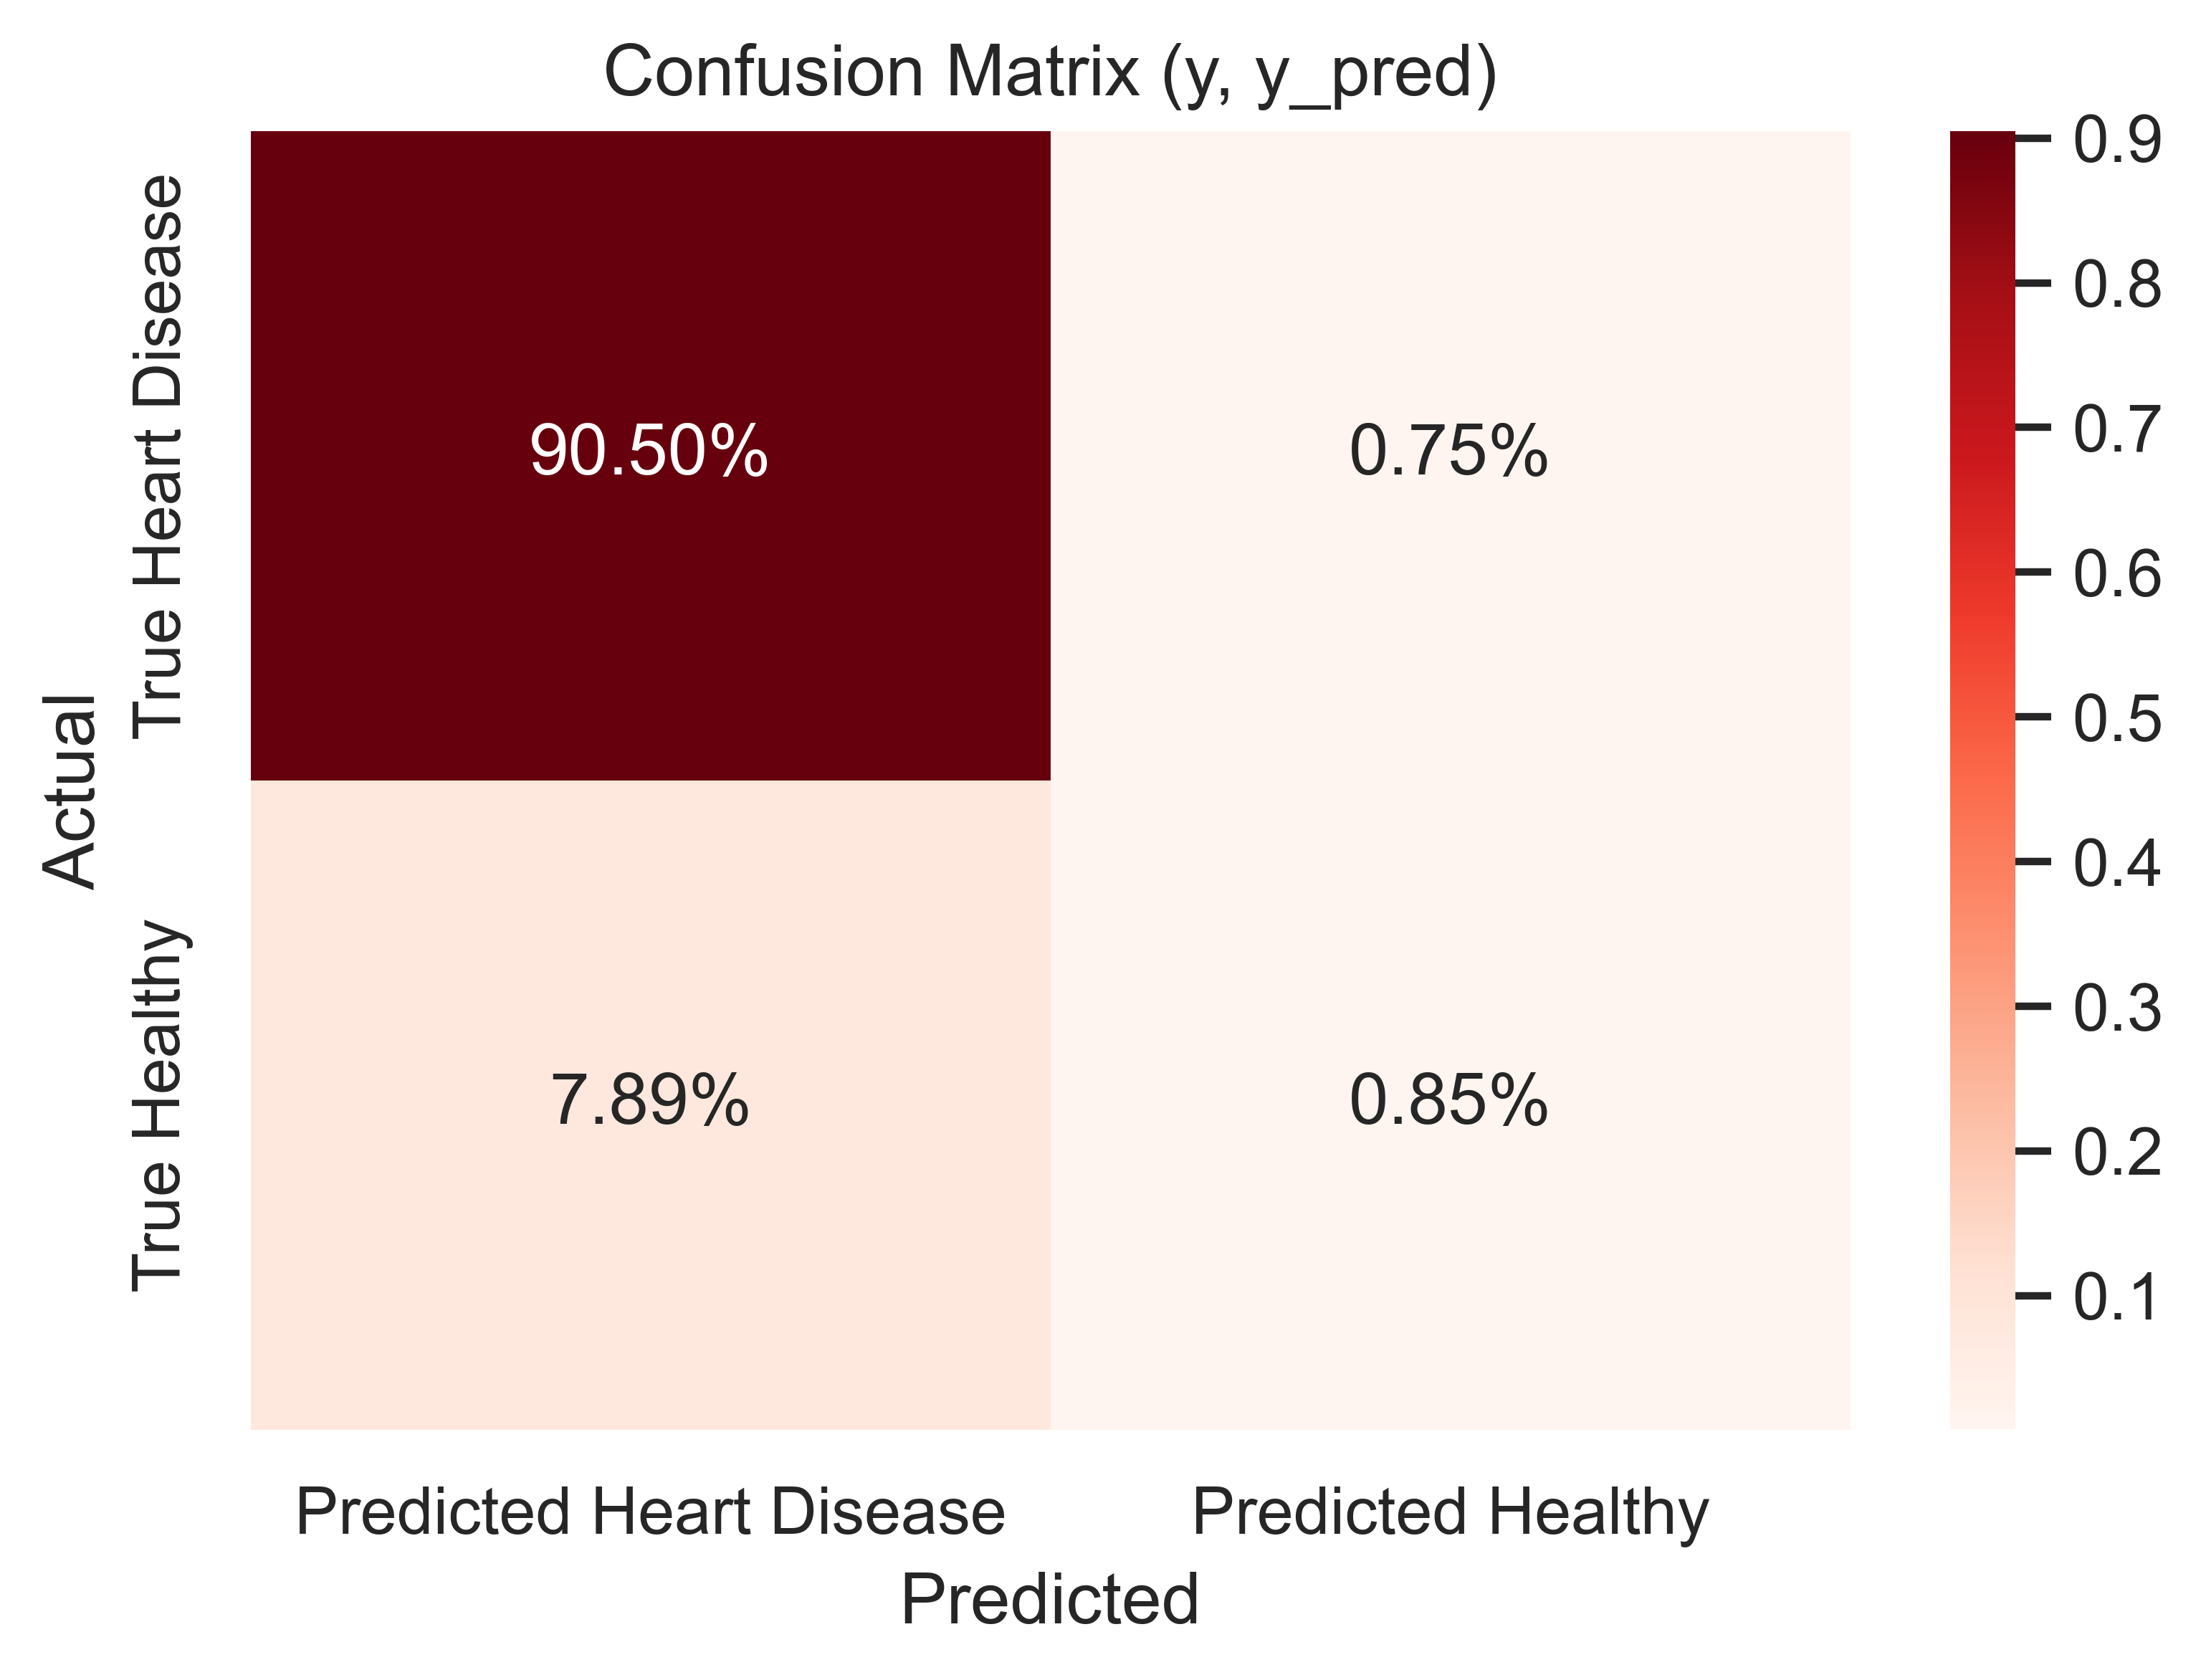

In [98]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

ax = sns.heatmap(cm_final/np.sum(cm_final),fmt='.2%', annot=True, cmap='Reds')

ax.xaxis.set_ticklabels(['Predicted Heart Disease','Predicted Healthy'])            #double check x y labels
ax.yaxis.set_ticklabels(['True Heart Disease','True Healthy'])

plt.title('Confusion Matrix (y, y_pred)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual ')

plt.savefig("confusion-matrix.jpeg");


In [100]:
# classification report 
print(classification_report(y_test, 
                            final_model.predict(X_test_scaled), 
                            target_names=['no heart disease', 'yes heart disease']))



                   precision    recall  f1-score   support

 no heart disease       0.92      0.99      0.95     58367
yes heart disease       0.53      0.10      0.16      5592

         accuracy                           0.91     63959
        macro avg       0.72      0.54      0.56     63959
     weighted avg       0.89      0.91      0.89     63959



[back to top](#top)

### 7.3 ROC AUC (X, y)<a id='73'></a> 

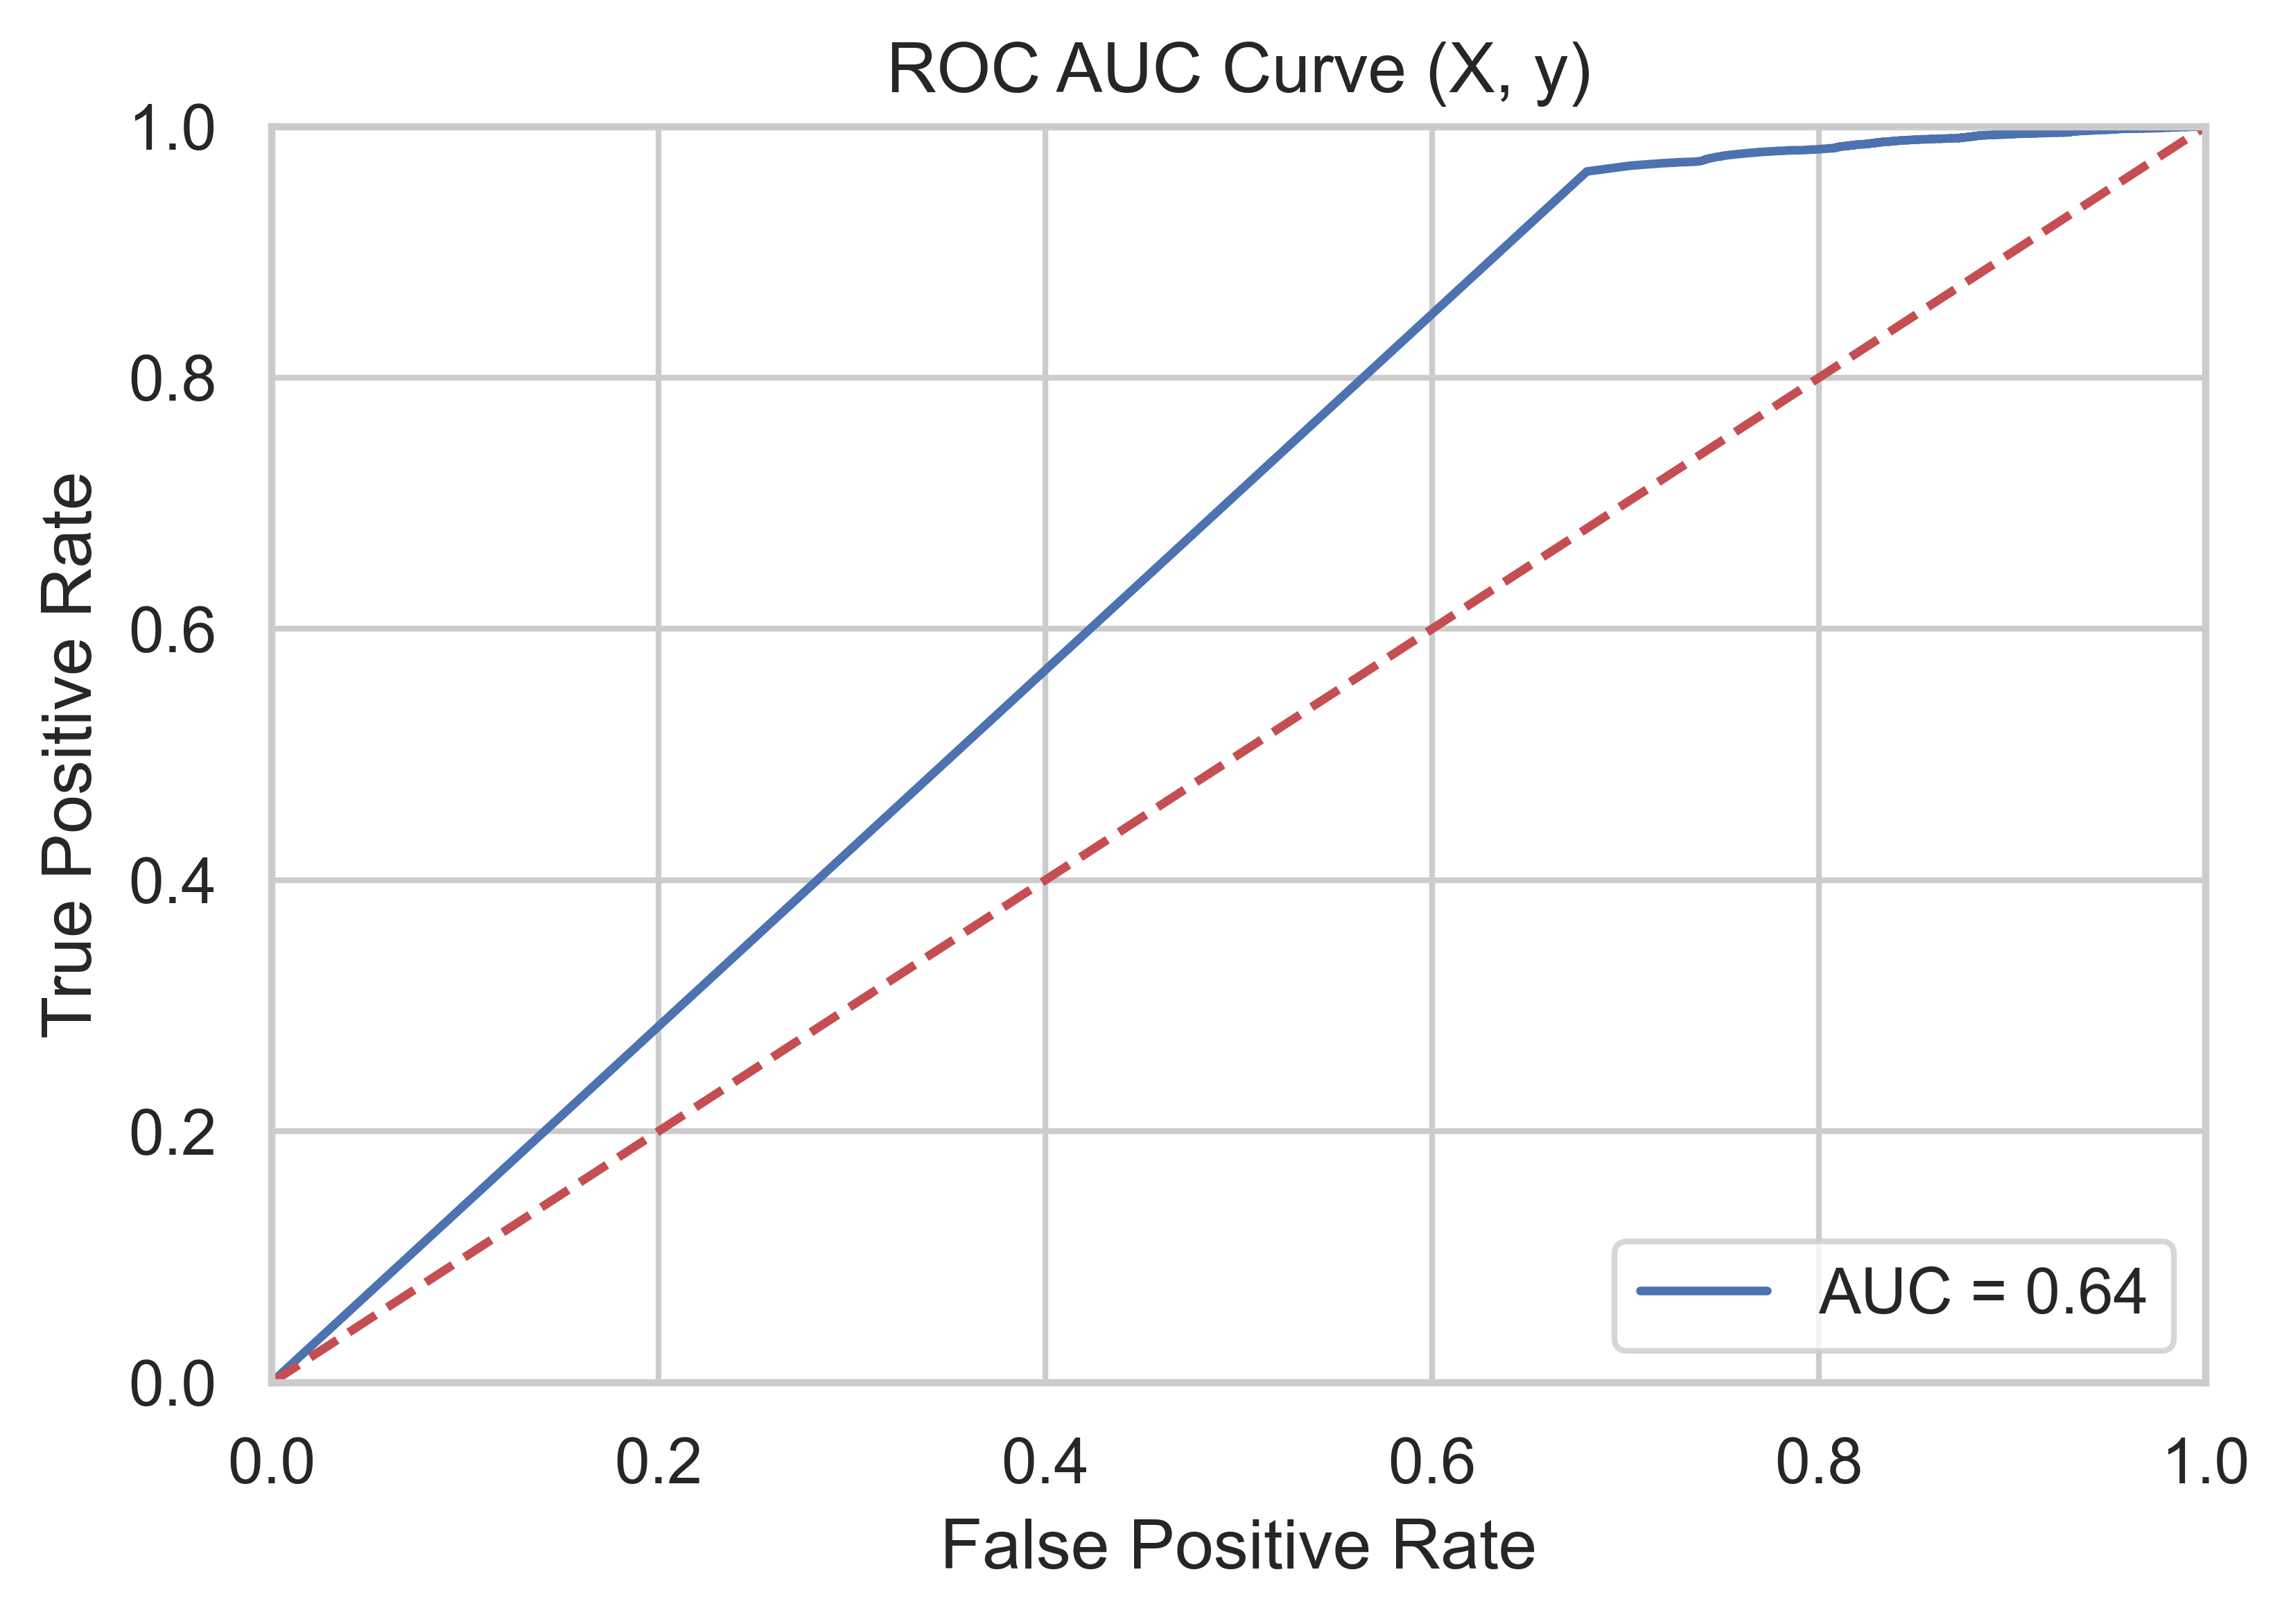

In [101]:
probs = final_model.predict_proba(X)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('ROC AUC Curve (X, y)')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("roc-auc-curve.jpeg");

[back to top](#top)

### 7.4 Feature Importance<a id='74'></a> 

In [102]:
imp_feat = pd.DataFrame()
feat = list(X)
imp = final_model.coef_[0]
imp_feat['Feature'] = feat
imp_feat['Importance'] = imp
imp_feat.sort_values(by=['Importance'], ascending=False, inplace=True)


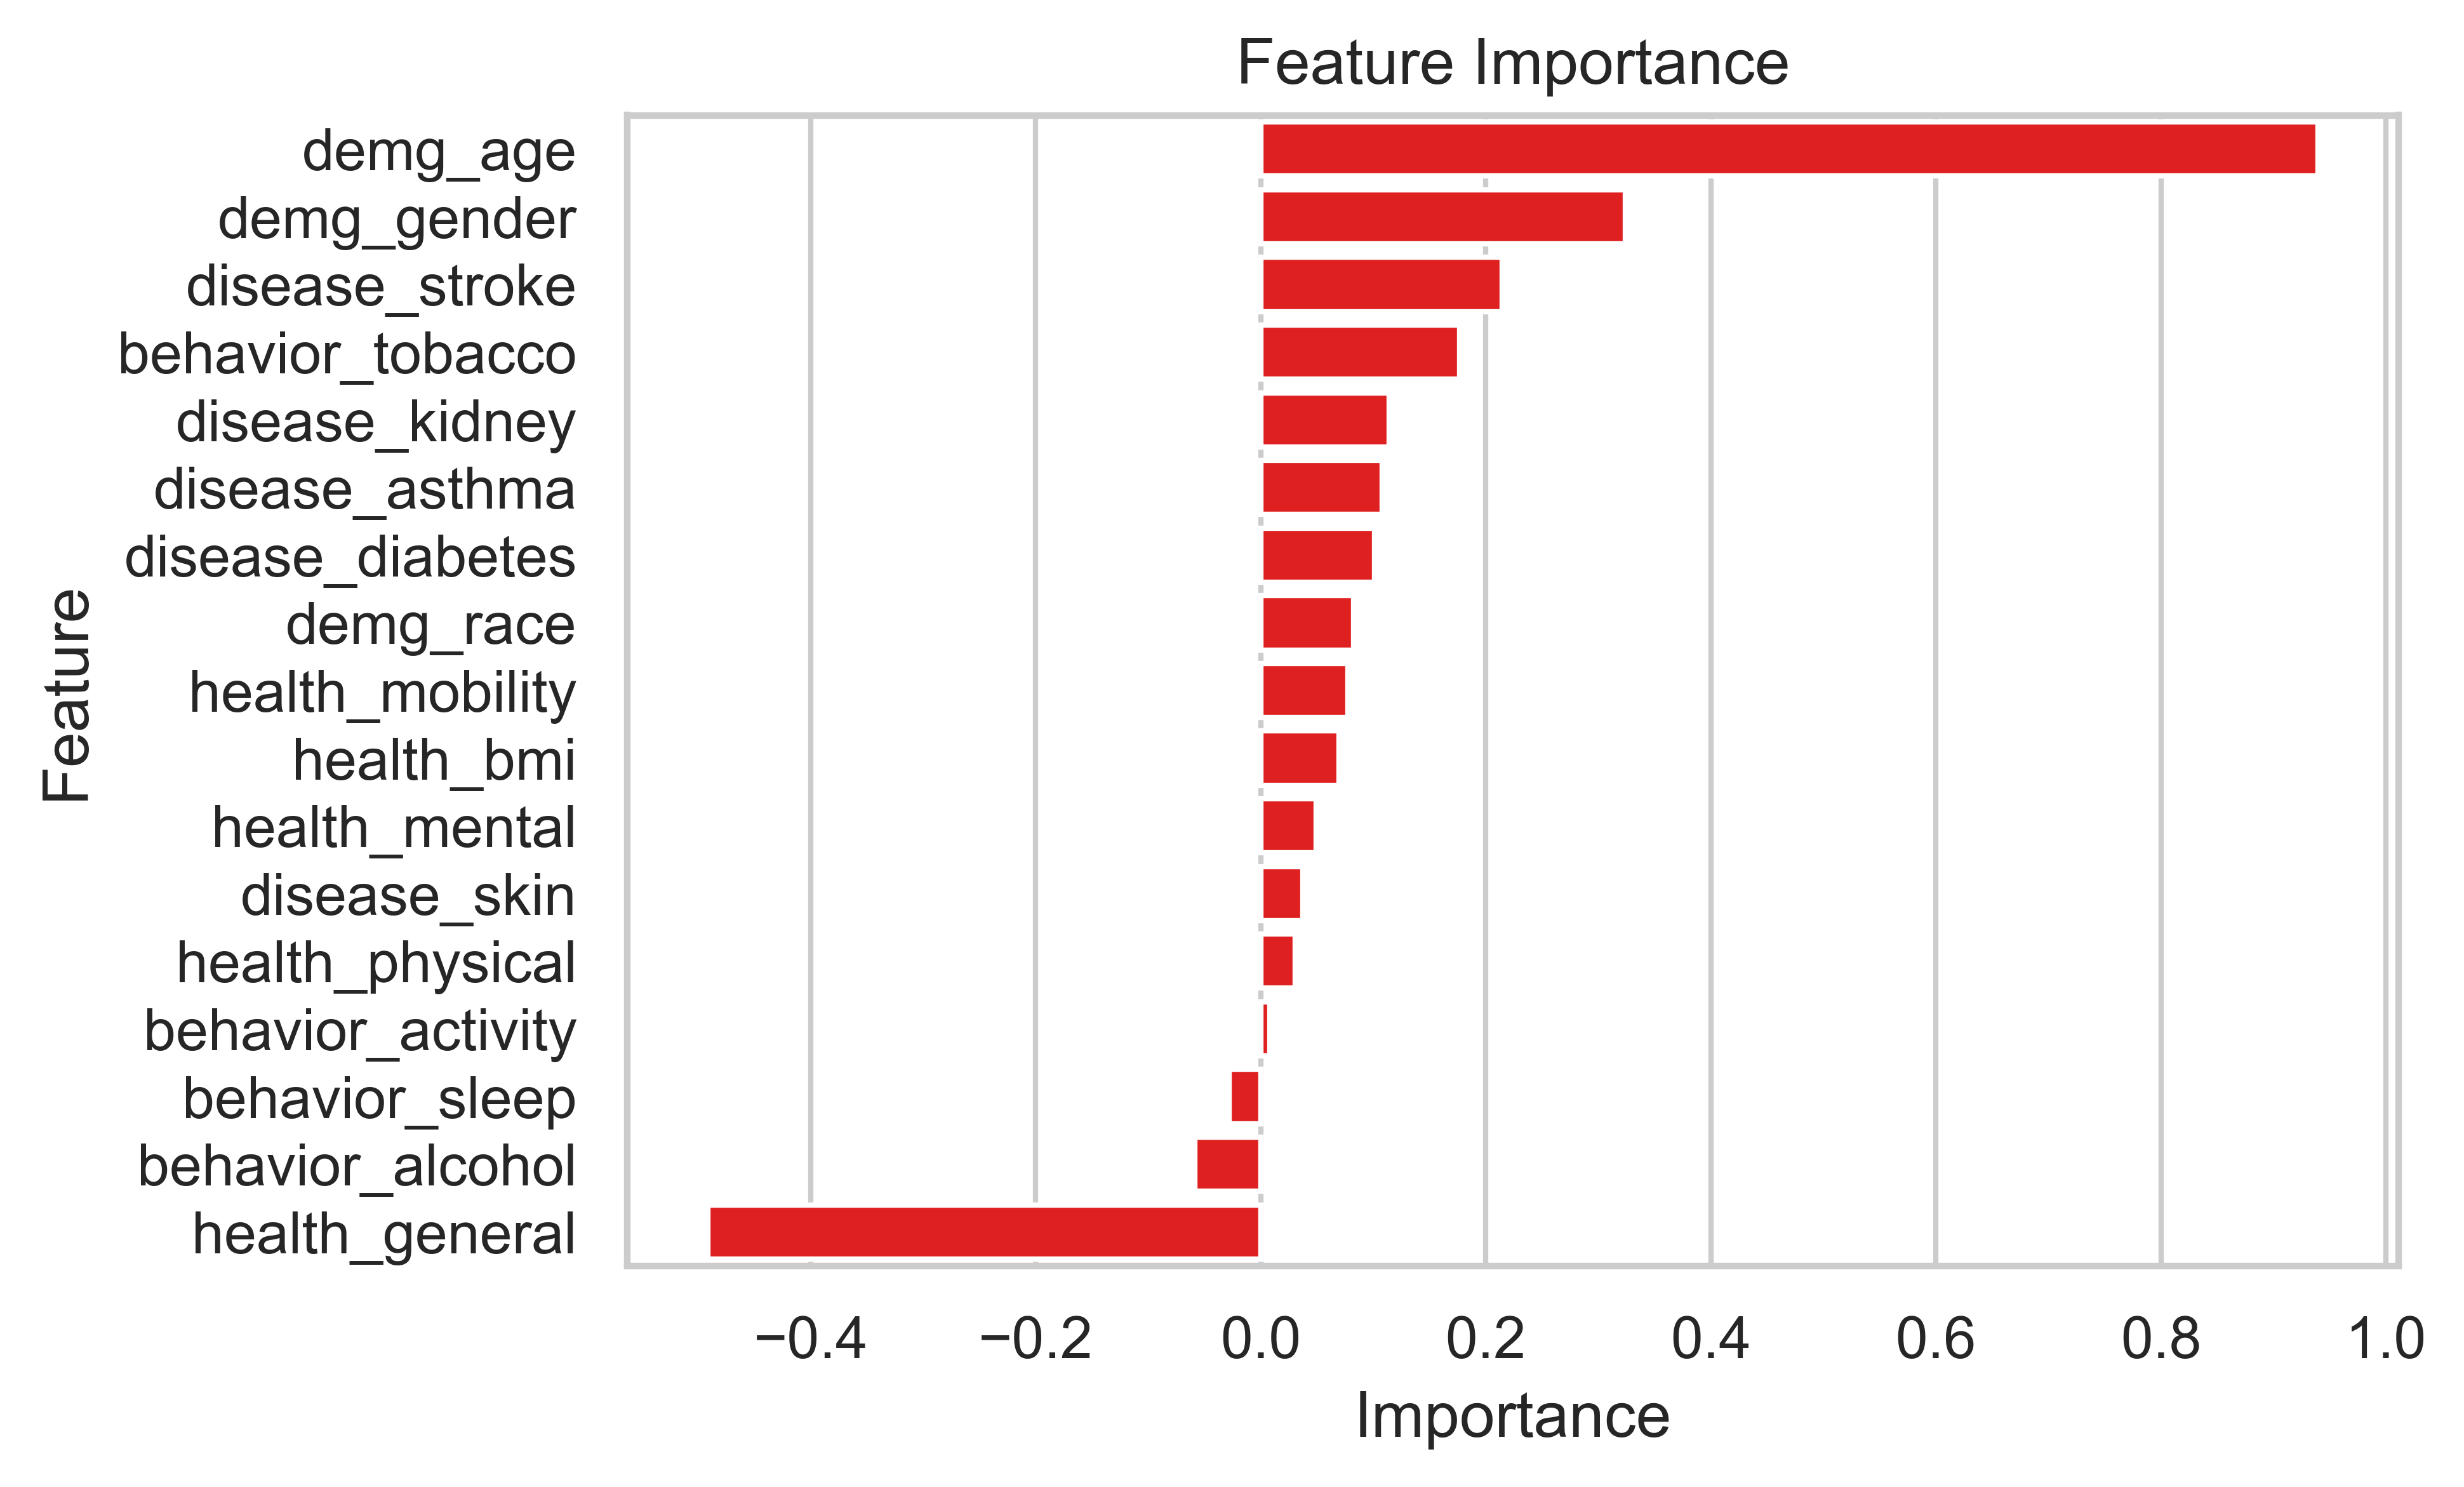

In [103]:
# vizualize feature importance
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

sns.barplot(x='Importance', y='Feature', data=imp_feat, color='red');
plt.title('Feature Importance')

plt.savefig("feature-importance.jpeg");


[back to top](#top)

### 7.5 Interpret<a id='75'></a> 

In [106]:
# refit model to make predictions
heart_disease_model = LogisticRegression(C=0.01, penalty="l2")
heart_disease_model.fit(X_scaled, y)
y_pred = heart_disease_model.predict(X) 
heart_disease_model

LogisticRegression(C=0.01)

Value references in [data dictionary](#1a) and [MVP transformations](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb). 


Top 4 impoartant features: age, gender, stroke, tobacco, kidney

In [143]:
# persona 1: middle aged, man, smoker, no chronic disease

X_p1 = [[55,  #'demg_age'     middle aged
         2,  #'demg_gender'   male
         0, #'disease_stroke'
         1, #'behavior_tobacco' smoker
         0, #'disease_kidney'

         # rest of features will remain constant
         1, #'behavior_activity' worksout regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'  
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi 
         3, #'health_general' health is good 
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p1 = heart_disease_model.predict(X_p1) 
y_pred_p_p1 = heart_disease_model.predict_proba(X_p1) 
print('Persona 1: middle aged, man, smoker, no chronic disease')
print('Yes/No heart disease:', y_pred_p1)
print('Probability of heart disease:', y_pred_p_p1)


Persona 1: middle aged, man, smoker, no chronic disease
Yes/No heart disease: [0]
Probability of heart disease: [[0.66563832 0.33436168]]


In [142]:
# persona 2: senior, male, stroke, smoker

X_p2 = [[75,  #'demg_age'     senior
         2,  #'demg_gender'   male
         1, #'disease_stroke' stroke
         1, #'behavior_tobacco' smoker
         0, #'disease_kidney'

         # rest of features will remain constant
         1, #'behavior_activity' worksout regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'  
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi 
         3, #'health_general' health is good 
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p2 = heart_disease_model.predict(X_p2) 
y_pred_p_p2 = heart_disease_model.predict_proba(X_p2) 
print('Persona 2: senior, male, stroke, smoker')
print('Yes/No heart disease:', y_pred_p2)
print('Probability of heart disease:', y_pred_p_p2)


Persona 2: senior, male, stroke, smoker
Yes/No heart disease: [0]
Probability of heart disease: [[0.64862893 0.35137107]]


In [145]:
# persona 3: young, woman, not smoker,  no chronic conditions

X_p3 = [[19,  #'demg_age'     senior
         1,  #'demg_gender'   male
         0, #'behavior_tobacco' notsmoker
         0, #'disease_stroke' stroke
         0, #'disease_kidney'

         # rest of features will remain constant
         1, #'behavior_activity' worksout regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'  
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi 
         3, #'health_general' health is good 
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p3 = heart_disease_model.predict(X_p3) 
y_pred_p_p3 = heart_disease_model.predict_proba(X_p3) 
print('Persona 3: young, woman, not smoker,  no chronic conditions')
print('Yes/No heart disease:', y_pred_p3)
print('Probability of heart disease:', y_pred_p_p3)


Persona 3: young, woman, not smoker,  no chronic conditions
Yes/No heart disease: [0]
Probability of heart disease: [[0.73137205 0.26862795]]


[back to top](#top)